In [3]:
#| export
verbose                       = None
check_memory_usage            = None
time_flag                     = None
window_size_percentage        = None
show_plots                    = None
reset_kernel                  = None
pre_configured_case           = None
case_id                       = None
frequency_factor              = None
frequency_factor_change_alias = None
check_parameters              = True
cuda_device                   = None
remove_lambdas_flag           = True

# Explained pre-trained module trial

## Instalation commands

In [ ]:
#! git clone https://github.com/SalesforceAIResearch/uni2ts.git
#! cd uni2ts
#! pip install -e '.[notebook]' --no-warn-script-location
#! conda install anaconda::gluonts

## Import libraries

In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

In [1]:
from dvats.all import *

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedInputStream size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedOutputStream size changed, may indicate binary 


Octave is ready <oct2py.core.Oct2Py object at 0x7f01575145e0>

















## Utilities

In [8]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

In [4]:
import importlib
def remove_lambdas(verbose = 0):
    path = "./uni2ts/src/uni2ts/distribution/mixture.py"
    if verbose > 0: print(f"remove_lambdas | read file {path}")
    # Read the file
    with open(path, 'r') as file:
        lines = file.readlines()
    # Check wether identity is defined or not
    identity_defined = any("def identity(" in line for line in lines)
    if verbose > 0: print(f"remove_lambdas | identity already defined? {identity_defined}")
    if not identity_defined: 
        if verbose > 0: print("remove_lambdas | Look for domain_map line")
        for i, line in enumerate(lines):
            if "@property" in line and "def domain_map" in lines[i+1]:                
                domain_map_property_index = i
                break
        if verbose > 0: print(f"remove_lambdas | Domain map in line {i}")
        # Insert identity function
        identity_code = """
    def identity(self, x): 
        return x

"""
        lines.insert(domain_map_property_index, identity_code)
        # Modify weights_logits line 
        inside_domain_map = False
        for i in range(domain_map_property_index, len(lines)):
            if "weights_logits" in lines[i]:
                # Reemplazar la línea para que use identity
                lines[i] = "            weights_logits = self.identity,\n"
                break
        # Write changes 
        with open(path, 'w') as file:
            file.writelines(lines)
        importlib.reload(uni2ts)
    else:
        if identity_defined:
            print("Identity already defined")    

### Ensure model is pickable

In [5]:
if remove_lambdas_flag: remove_lambdas(verbose = 2)

remove_lambdas | read file ./uni2ts/src/uni2ts/distribution/mixture.py
remove_lambdas | identity already defined? True
Identity already defined


## Load dataset artifact

### Check input parameters & set up default parameters

In [9]:
#| export
verbose                       = True  if verbose is None else verbose
check_memory_usage            = True  if check_memory_usage is None else check_memory_usage
time_flag                     = True  if time_flag is None else time_flag
window_size_percentage        = False if window_size_percentage is None else window_size_percentage
show_plots                    = True if show_plots is None else show_plots
reset_kernel                  = False  if reset_kernel is None else reset_kernel
pre_configured_case           = True if pre_configured_case is None else pre_configured_case
case_id                       = 7 if case_id is None else case_id
frequency_factor              = 1 if frequency_factor is None else frequency_factor
frequency_factor_change_alias = True if frequency_factor_change_alias is None else frequency_factor_change_alias
cuda_device                   = 1 if  cuda_device is None else cuda_device

In [7]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        "verbose:", verbose,
        "check_memory_usage", check_memory_usage,
        "time_flag:", time_flag,
        "window_size_percentage:" , window_size_percentage,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias", frequency_factor_change_alias,
        "cuda_device", cuda_device
)

--- Check parameters ---
verbose: True check_memory_usage True time_flag: True window_size_percentage: False show_plots: True reset_kernel: False pre_configured_case: True case_id: 7 frequency_factor: 1 frequency_factor_change_alias True cuda_device 1


In [13]:
#| export
import dvats.config as cfg_
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb

import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_next_multi
import pyarrow.feather as ft

In [14]:
#| export
wandb_api = wandb.Api()
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    gpu_memory_status(gpu_device)
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        verbose = verbose, 
        both = verbose > 0,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )
path = os.path.expanduser("~/work/nbs_pipeline/")
name="moirai_trial"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if verbose > 0: print("runname: "+runname)
if verbose > 0: cfg_.show_attrdict(config)

if verbose > 0: print("--> Wandb init")
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', 
    resume=False,
    name = runname
)
if verbose > 0: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
config = run.config  # Object for storing hyperparameters
if verbose > 0: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if verbose > 0: print("---> W&B Train Artifact")
df_train = train_artifact.to_df()
df_train.shape

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/moirai_trial.ipynb.


GPU | Used mem: 7
GPU | Used mem: 24
GPU | Memory Usage: [█████---------------] 29%
valid_size: 0.2
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest -> mi-santamaria/deepvats/toy:latest
alias: PulsusParadoxus-SP02 -> toy
use_wandb: True
r: 0.71
mask_future: False
valid_artifact: None
batch_size: 512 -> 32
data_fpath is missing in original dict | ~/data/toy.csv 
data_cols is missing in original dict | [] 
w: 100 -> 30
analysis_mode: online
stride: 900 -> 1
mvp_ws: (15, 100) -> [10, 30]
norm_use_by_single_batch is missing in original dict | (False,) 
mask_stateful: True
wandb_group: None
epochs: 100
mask_sync: False
time_col is missing in original dict | None 
norm_by_sample: False
freq is missing in original dict | 1s 
artifact_name is missing in original dict | toy 
norm_use_single_batch: False
csv_config is missing in original dict | {} 
runname: moirai_trial
alias: toy
analysis_mode: online
batch_size: 32
epochs: 100
mask_future: False
mask_stateful: True
mask_sync:

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->
alias: toy
analysis_mode: online
batch_size: 32
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [10, 30]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 1
train_artifact: mi-santamaria/deepvats/toy:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None
artifact_name: toy
data_cols: []
data_fpath: ~/data/toy.csv
freq: 1s
time_col: None
csv_config: {}
norm_use_by_single_batch: [False]
---> W&B Train Artifact


wandb:   1 of 1 files downloaded.  


(550, 3)

In [15]:
display(df_train.head())

,T3,T2,T1
1970-01-01 00:00:00,0.741822,0.637180,0.565117
1970-01-01 00:00:01,0.739731,0.629415,0.493513
1970-01-01 00:00:02,0.718757,0.539220,0.469350
1970-01-01 00:00:03,0.730169,0.577670,0.444100
1970-01-01 00:00:04,0.752406,0.570180,0.373008


### Sliding windows

In [22]:
#| export
if verbose > 0: print("---> Sliding window | ", config.w,  " | ", config.stride )
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])
if verbose > 0: print(" Sliding window | ", config.w,  " | ", config.stride, "---> | df_train ~ ", df_train.shape )
X_train, _ = sw(df_train)
if verbose > 0: print(" sw_df_train | ", config.w,  " | ", config.stride, "--->" )

---> Sliding window |  30  |  1
 Sliding window |  30  |  1 ---> | df_train ~  (550, 3)
 sw_df_train |  30  |  1 --->


In [23]:
#| hide
if verbose > 0: 
    print(X_train.shape)

(521, 3, 30)


len(X):  521
--> Split 1


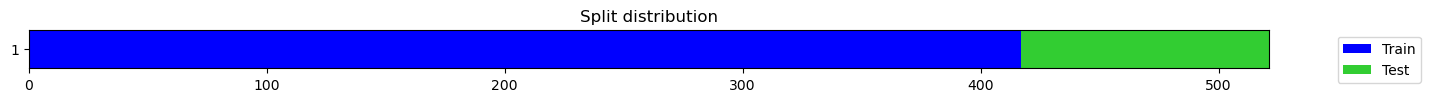

Split --> 417


In [27]:
#| export
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

X = X_train
if verbose > 0: print("len(X): ", len(X));
if config.analysis_mode == 'online':
    if verbose > 0: print("--> Split 1")
    splits = TimeSplitter(valid_size=0.2, show_plot=show_plots)(X)
elif config.analysis_mode == 'offline':
    if verbose > 0: print("--> Split 2")
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size, show_plot = show_plots)
if verbose > 0: 
    print("Split -->", len(splits[0]))


In [28]:
#| hide
if verbose > 0: 
    print(X.shape)
    display(splits)

(521, 3, 30)


((#417) [0,1,2,3,4,5,6,7,8,9...],
 (#104) [417,418,419,420,421,422,423,424,425,426...])

## Load & get embeddings from moirai module

In [26]:
def create_variate_id(
    batch_size, 
    seq_len, 
    num_variates
):
    # Crear un tensor de variate_id con tamaño (batch_size, seq_len, num_variates)
    variate_id = torch.arange(num_variates).unsqueeze(0).unsqueeze(0).repeat(batch_size, seq_len, 1)
    return variate_id

In [29]:
batch_size, num_variates, seq_len = X.shape

Aquí tendremos que seleccionar cualquiera de los modelos preentrenados en Moirai

In [ ]:
model_size = 'small'

Nuestro X tiene tamaño 
num_ventanas x num_variables x tamaño_ventana

El target que recibe Moirai tiene tamaño 
num_ventanas x tamaño_ventana x num_variables

Permutamos para ajustar la entrada correctamente

In [30]:
# Create target ~ ( batch , seq_length , max_patch )
target = torch.randn(batch_size, seq_len, num_variates)
target.shape

torch.Size([521, 30, 3])

Como todos los valores son observados, hacemos que el observed mask esté a 1
Como el tamaño es el mismo que el del target, usamos torch.ones

In [31]:
# observed_mask ~ (batch , seq_len , max_patch )
observed_mask = torch.ones(target.shape)
observed_mask.shape

torch.Size([521, 30, 3])

MoiraiModule necesita un id para cada muestra
Creamos un índice numérico para cada sample

In [79]:
# sample ~ ( batch, seq_len )
sample_id = torch.arange(batch_size).unsqueeze(1).repeat(1, seq_len)
sample_id.shape

torch.Size([521, 30])

In [80]:
variate_ids = torch.arange(num_variates).unsqueeze(0).unsqueeze(0) 
print(variate_ids)

tensor([[[0, 1, 2]]])


In [82]:
variate_id_tensor = variate_ids.repeat(batch_size, seq_len, 1)
print(variate_id_tensor.shape)
print(variate_id_tensor[0][0])

torch.Size([521, 30, 3])
tensor([0, 1, 2])


In [84]:
variate_id_tensor = variate_id_tensor.permute(0, 2, 1).reshape(batch_size, seq_len * num_variates)

In [85]:
variate_id_tensor.shape

torch.Size([521, 90])

También necesita un índice de tiempo (que no es el propio timestamp porque tiene que ser numérico)

In [38]:
# time_id ~ ( batch , seq_len )
time_id = torch.arange(seq_len) # [0 .. seq_len-1 ]]
print(time_id) 
time_id = time_id.unsqueeze(0) # [[0..seq_len -1]]
print(time_id)
time_id = time_id.repeat(batch_size, 1) # [[ 0 .. seq_len-1 ] , ..., [0, .., seq_len-1]]
print(time_id)
time_id.shape

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])
tensor([[ 0,  1,  2,  ..., 27, 28, 29],
        [ 0,  1,  2,  ..., 27, 28, 29],
        [ 0,  1,  2,  ..., 27, 28, 29],
        ...,
        [ 0,  1,  2,  ..., 27, 28, 29],
        [ 0,  1,  2,  ..., 27, 28, 29],
        [ 0,  1,  2,  ..., 27, 28, 29]])


torch.Size([521, 30])

In [39]:
# variate = feature = channel
# Indices for the variates
# variate_id ~ (batch x seq_len ) 
variate_id = torch.arange(num_variates).unsqueeze(0).unsqueeze(0).repeat(batch_size, seq_len, 1)
variate_id.shape

torch.Size([521, 30, 3])

In [24]:


variate_id = None # batch x seq_len
prediction_mask = None # batch x seq_len 
# Tamaño de cada patch
patch_size = None # batch x seq_len 

In [ ]:

variate_id = create_variate_id (
    

In [21]:
# Get pre-trained module
module = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{model_size}")

#### Segundo intento

In [86]:
batch_size, num_variates, seq_len  = X.shape

In [89]:
target = torch.from_numpy(X).permute(0, 2, 1)
target.shape

torch.Size([521, 30, 3])

In [92]:
observed_mask = torch.ones(batch_size, seq_len, num_variates, dtype=torch.bool)
observed_mask.shape

torch.Size([521, 30, 3])

In [93]:
sample_id = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1)
sample_id.shape

torch.Size([521, 30])

In [94]:
time_id = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1)
time_id.shape

torch.Size([521, 30])

In [96]:
variate_ids = torch.arange(num_variates).unsqueeze(0).repeat(batch_size, seq_len, 1)
variate_ids.shape

torch.Size([521, 30, 3])

sé que tiene sentido, porque además dicen que aplanan las variables en la primera capa del modelo, pero esque en todas partes de la documentación indican batch x seq_len

In [97]:
variate_id = variate_ids.permute(0, 2, 1).reshape(batch_size, seq_len * num_variates)
variate_id.shape

torch.Size([521, 90])

In [98]:
prediction_mask = torch.ones(batch_size, seq_len, dtype=torch.bool)
patch_size_tensor = torch.full((batch_size, seq_len), patch_size, dtype=torch.int)

In [99]:
output = module.forward(
    target=target,
    observed_mask=observed_mask,
    sample_id=sample_id,
    time_id=time_id,
    variate_id=variate_id,
    prediction_mask=prediction_mask,
    patch_size=patch_size_tensor,
)

RuntimeError: The size of tensor a (30) must match the size of tensor b (90) at non-singleton dimension 2

Tercer intento

In [100]:
X.shape

(521, 3, 30)

In [106]:
num_windows, num_variates, window_len = X.shape

In [102]:
target = X.reshape(521, -1)
target.shape

(521, 90)

In [110]:
batch_size = num_windows
seq_len = window_len * num_variates
patch_size = 64
max_patch = patch_size

In [111]:
observed_mask = torch.ones(batch_size, seq_len, max_patch, dtype=torch.bool)
observed_mask.shape

torch.Size([521, 90, 64])

In [114]:
sample_id = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1)
sample_id.shape

torch.Size([521, 90])

In [116]:
time_id = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1)
time_id.shape

torch.Size([521, 90])